In [1]:
from math import radians, cos, sin, asin, sqrt 
def calculate_distance(lon1, lat1, lon2, lat2): 
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2]) 
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2 
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371 
    km = 6371* c 
    return km

In [2]:
def next_cluster(lng,lat,cluster_df):
    smallest_value = 9999999999999999
    for index, row in cluster_df.iterrows():
        cluster_lng = row["lng"]
        cluster_lat = row["lat"]
        distance = calculate_distance(lng,lat,cluster_lng,cluster_lat)
        if distance < smallest_value:
            smallest_value = distance
            closest_cluster = [cluster_lng,cluster_lat]
    return closest_cluster

# Task 1

## Import Libraries

In [3]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
import geopandas as gpd

## Import raw data and merge the data

In [6]:
Nextbike_bochum= pd.read_csv("./dataset/bochum.csv")
Nextbike_leipzig = pd.read_csv("./dataset/leipzig.csv")
Nextbike = Nextbike_bochum.append(Nextbike_leipzig)

Nextbike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 202697 entries, 0 to 185326
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   day            202697 non-null  object 
 1   time           202697 non-null  object 
 2   b_number       202697 non-null  int64  
 3   city           202697 non-null  object 
 4   trip_duration  202697 non-null  object 
 5   orig_lat       202697 non-null  float64
 6   orig_lng       202697 non-null  float64
 7   dest_lat       202697 non-null  float64
 8   dest_lng       202697 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 15.5+ MB


In [7]:
date_info_leipzig = pd.read_csv("./resources/leipzig-holidays/leipzig-holidays.csv",sep=";")
date_info_leipzig["date"] = pd.to_datetime(date_info_leipzig["date"],format="%d.%m.%Y").dt.date
date_info_leipzig.index = date_info_leipzig["date"]


## Look for null values

In [8]:
Nextbike.isnull().sum().sort_values(ascending=False)

day              0
time             0
b_number         0
city             0
trip_duration    0
orig_lat         0
orig_lng         0
dest_lat         0
dest_lng         0
dtype: int64

## Correct Data Types

In [9]:
#Converting Trip Length to timedelta
Nextbike['trip_duration'] = pd.to_timedelta(Nextbike['trip_duration'])

#Converting start-time to datetime
Nextbike['timestamp'] = pd.to_datetime(Nextbike['day'] + ' ' +  Nextbike['time'])
Nextbike.drop(columns=['day','time'], inplace = True)

## Add columns for analysis

In [10]:
#Round datetime and extract possible categorisation attributes
Nextbike['timestamp_rounded'] = Nextbike['timestamp'].dt.floor('H')

Nextbike['weekday'] = Nextbike['timestamp_rounded'].dt.weekday
Nextbike['week'] = Nextbike['timestamp_rounded'].dt.isocalendar().week

Nextbike['Time'] = Nextbike['timestamp_rounded'].dt.time
Nextbike["Time"] = Nextbike["Time"].astype(str).str[:2].astype(int)

Nextbike["date"] = Nextbike.timestamp.dt.date
#Nextbike_clean["date_str"] = Nextbike_clean.timestamp.dt.date.astype(str)

#take trip duration in minutes, calculate 1€ per 30 minutes of usage
Nextbike["revenue"] = np.ceil((Nextbike.trip_duration.dt.total_seconds()/60) /30)


#output
Nextbike

,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,timestamp,timestamp_rounded,weekday,week,Time,date,revenue
0,683,bochum,0 days 00:10:00,51.489814,7.232856,51.479592,7.222239,2019-02-08 12:06:00,2019-02-08 12:00:00,4,6,12,2019-02-08,1.0
1,683,bochum,0 days 00:14:00,51.479592,7.222239,51.472366,7.250500,2019-02-10 01:58:00,2019-02-10 01:00:00,6,6,1,2019-02-10,1.0
2,683,bochum,0 days 00:28:00,51.472366,7.250500,51.479592,7.222239,2019-02-11 06:33:00,2019-02-11 06:00:00,0,7,6,2019-02-11,1.0
3,683,bochum,0 days 00:58:00,51.479592,7.222239,51.483023,7.215314,2019-02-11 13:31:00,2019-02-11 13:00:00,0,7,13,2019-02-11,2.0
4,683,bochum,0 days 00:22:00,51.483023,7.215314,51.479592,7.222239,2019-02-11 14:32:00,2019-02-11 14:00:00,0,7,14,2019-02-11,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185322,99979,leipzig,0 days 00:07:00,51.468822,11.290048,51.468547,11.289899,2019-05-25 10:58:00,2019-05-25 10:00:00,5,21,10,2019-05-25,1.0
185323,99979,leipzig,0 days 01:16:00,51.468756,11.289723,51.469324,11.289366,2019-05-27 09:32:00,2019-05-27 09:00:00,0,22,9,2019-05-27,3.0
185324,99979,leipzig,0 days 00:03:00,51.469044,11.289348,51.469093,11.289432,2019-05-27 11:02:00,2019-05-27 11:00:00,0,22,11,2019-05-27,1.0
185325,99982,leipzig,0 days 01:44:00,51.341165,12.365045,51.341065,12.365005,2019-02-11 11:47:00,2019-02-11 11:00:00,0,7,11,2019-02-11,4.0


## Split data for analysis

In [11]:
Nextbike_clean_l = Nextbike[Nextbike.city == "leipzig"]
Nextbike_clean_b = Nextbike[Nextbike.city == "bochum"]

leipzig = {"lng": 12.3741468,"lat": 51.340744}

city = leipzig
df = Nextbike_clean_l.copy()
date_info = date_info_leipzig.copy()

## Cleaning up unrealistic rides
This step is aimed at filtering out rides that have start or end locations far out from the city and thus is likely not a regular ride within the valid area

In [12]:
max_distance_center = []

for index, row in df.iterrows():
    s = calculate_distance(lon1 = row["orig_lng"],
                       lat1 = row["orig_lat"],
                       lon2 = city["lng"],
                       lat2 = city["lat"])
    e = calculate_distance(lon1 = row["dest_lng"], 
                           lat1 = row["dest_lat"],
                           lon2 = city["lng"],
                           lat2 = city["lat"])
    max_distance_center.append(max([s,e]))

df["max_distance_center"] = max_distance_center
df

,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,timestamp,timestamp_rounded,weekday,week,Time,date,revenue,max_distance_center
0,10900,leipzig,0 days 00:12:00,51.330271,12.341983,51.330347,12.342159,2019-04-16 11:17:00,2019-04-16 11:00:00,1,16,11,2019-04-16,1.0,2.519655
1,10900,leipzig,0 days 00:08:00,51.330347,12.342159,51.330271,12.342199,2019-04-16 11:35:00,2019-04-16 11:00:00,1,16,11,2019-04-16,1.0,2.506386
2,10900,leipzig,0 days 00:40:00,51.330267,12.342196,51.330236,12.342012,2019-04-16 11:53:00,2019-04-16 11:00:00,1,16,11,2019-04-16,2.0,2.519708
3,10900,leipzig,0 days 00:03:00,51.330298,12.341811,51.330267,12.341958,2019-04-16 14:35:00,2019-04-16 14:00:00,1,16,14,2019-04-16,1.0,2.528907
4,20000,leipzig,0 days 00:20:00,51.343107,12.376471,51.330422,12.337838,2019-05-21 09:47:00,2019-05-21 09:00:00,1,21,9,2019-05-21,1.0,2.771228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185322,99979,leipzig,0 days 00:07:00,51.468822,11.290048,51.468547,11.289899,2019-05-25 10:58:00,2019-05-25 10:00:00,5,21,10,2019-05-25,1.0,76.539147
185323,99979,leipzig,0 days 01:16:00,51.468756,11.289723,51.469324,11.289366,2019-05-27 09:32:00,2019-05-27 09:00:00,0,22,9,2019-05-27,3.0,76.590965
185324,99979,leipzig,0 days 00:03:00,51.469044,11.289348,51.469093,11.289432,2019-05-27 11:02:00,2019-05-27 11:00:00,0,22,11,2019-05-27,1.0,76.586597
185325,99982,leipzig,0 days 01:44:00,51.341165,12.365045,51.341065,12.365005,2019-02-11 11:47:00,2019-02-11 11:00:00,0,7,11,2019-02-11,4.0,0.635997


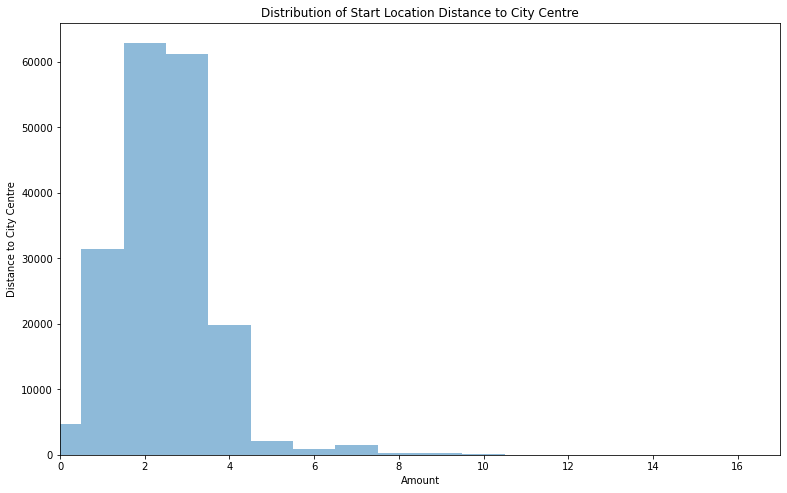

In [13]:
df["max_distance_center"] = df["max_distance_center"].round()

distances = df.groupby("max_distance_center").agg(
count = ("b_number","count"))

# Create a figure (empty work space)
Fig_1 = plt.figure(figsize=(10,6))

# Add axes to the figure
ax_1 = Fig_1.add_axes([0.5, 0.5, 1, 1]) #The dimensions [left, bottom, width, height] of the axes

x = distances.index
y1 = distances["count"]
start_bars = ax_1.bar(x,y1,width = 1,alpha = 0.5)


ax_1.set_xlabel('Amount') # Use set_ to start method
ax_1.set_ylabel('Distance to City Centre')
ax_1.set_title('Distribution of Start Location Distance to City Centre')

plt.xlim([0,17])
plt.show()

In [14]:
df_unrealistic = df[df["max_distance_center"]>15]
print(len(df_unrealistic.index),"have been filtered out due to being too far away from the city centre.")
df = df[df["max_distance_center"]<=15]

24 have been filtered out due to being too far away from the city centre.


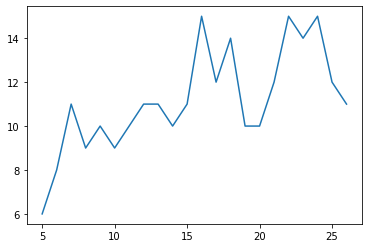

In [15]:
operating_area = df.groupby("week").agg(
    distance = ("max_distance_center","max"))
plt.plot(operating_area)

## Find out size of the fleet
The idea is that a bike is recognized as part of the fleet if it has been rented in the last 7 days. So the size of the fleet is the amount of unique Bike IDs that have records for the last 7 days. We calculate this on a daily level to be precise yet not too intense to compute.

In [16]:
factor = 7

start_date = df.date.min()
end_date = df.date.max()
delta = pd.to_timedelta("1d")

dates = []
while start_date <= end_date:
    dates.append(start_date)
    start_date += delta



fleet_size = pd.DataFrame([], index = dates, columns = ["search_array","fleet_size"]) 

search_array = []
for index, row in fleet_size.iterrows():
    search_array.append(index)
    if len(search_array) > factor:
        search_array.pop(0)
    row['search_array'] = search_array[:] #This just helps see if everything goes as expected
    row['fleet_size'] = df[df.date.isin(search_array[:])].b_number.nunique()
    
fleet_size.drop(columns=["search_array"], inplace = True)

In [17]:
fleet_size

,fleet_size
2019-02-01,256
2019-02-02,329
2019-02-03,350
2019-02-04,390
2019-02-05,421
...,...
2019-06-26,785
2019-06-27,787
2019-06-28,789
2019-06-29,795


In [18]:
df_by_date = df.groupby("date").agg(
    revenue=('revenue', "sum"),
    trips=("b_number","count"),
    used_bikes=('b_number', pd.Series.nunique))

df_by_date_merged = df_by_date.join(fleet_size) #this does not include the missing days
df_by_date_merged["usage"] = df_by_date_merged["used_bikes"] / df_by_date_merged["fleet_size"]
df_by_date_merged = df_by_date_merged.rename(columns={"trips": "daily_trips","revenue":"daily_revenue", "used_bikes":"daily_used_bikes"})
df_by_date_merged = pd.merge( df_by_date_merged, date_info, left_index=True, right_index=True)

df_by_date_merged = df_by_date_merged.drop(columns=["date"])
df_by_date_merged

,daily_revenue,daily_trips,daily_used_bikes,fleet_size,usage,day_classifier,vacations,holiday
date,,,,,,,,
2019-02-01,785.0,659,256,256,1.000000,weekday,0,0
2019-02-02,664.0,526,241,329,0.732523,weekend,0,0
2019-02-03,352.0,285,162,350,0.462857,weekend,0,0
2019-02-04,623.0,499,237,390,0.607692,weekday,0,0
2019-02-05,654.0,573,251,421,0.596200,weekday,0,0
...,...,...,...,...,...,...,...,...
2019-06-26,3039.0,2552,585,785,0.745223,weekday,0,0
2019-06-27,2993.0,2555,600,787,0.762389,weekday,0,0
2019-06-28,3417.0,2857,627,789,0.794677,weekday,0,0


In [19]:
df_by_hour = df.groupby("timestamp_rounded").agg(
    revenue=('revenue', "sum"),
    trips=("b_number","count"),
    date=("date","min"),
    weekday=("weekday","min"),
    week = ("week","min"),
    time = ("Time","min"),
    used_bikes=('b_number', pd.Series.nunique))


df_by_hour_merged = pd.merge(df_by_hour, df_by_date_merged, right_index=True, left_on='date')


df_by_hour_merged["usage"] = df_by_hour_merged["used_bikes"] / df_by_hour_merged["fleet_size"]
df_by_hour_merged["relative_trips"] = df_by_hour_merged["trips"] / df_by_hour_merged["daily_trips"]



df_by_hour_merged

,revenue,trips,date,weekday,week,time,used_bikes,daily_revenue,daily_trips,daily_used_bikes,fleet_size,usage,day_classifier,vacations,holiday,relative_trips
timestamp_rounded,,,,,,,,,,,,,,,,
2019-02-01 00:00:00,9.0,8,2019-02-01,4,5,0,8,785.0,659,256,256,0.031250,weekday,0,0,0.012140
2019-02-01 01:00:00,9.0,7,2019-02-01,4,5,1,7,785.0,659,256,256,0.027344,weekday,0,0,0.010622
2019-02-01 02:00:00,7.0,2,2019-02-01,4,5,2,2,785.0,659,256,256,0.007812,weekday,0,0,0.003035
2019-02-01 03:00:00,3.0,3,2019-02-01,4,5,3,3,785.0,659,256,256,0.011719,weekday,0,0,0.004552
2019-02-01 04:00:00,9.0,8,2019-02-01,4,5,4,8,785.0,659,256,256,0.031250,weekday,0,0,0.012140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30 19:00:00,112.0,90,2019-06-30,6,26,19,85,2174.0,1700,499,790,0.107595,weekend,0,0,0.052941
2019-06-30 20:00:00,104.0,87,2019-06-30,6,26,20,82,2174.0,1700,499,790,0.103797,weekend,0,0,0.051176
2019-06-30 21:00:00,82.0,66,2019-06-30,6,26,21,62,2174.0,1700,499,790,0.078481,weekend,0,0,0.038824


# Task 2

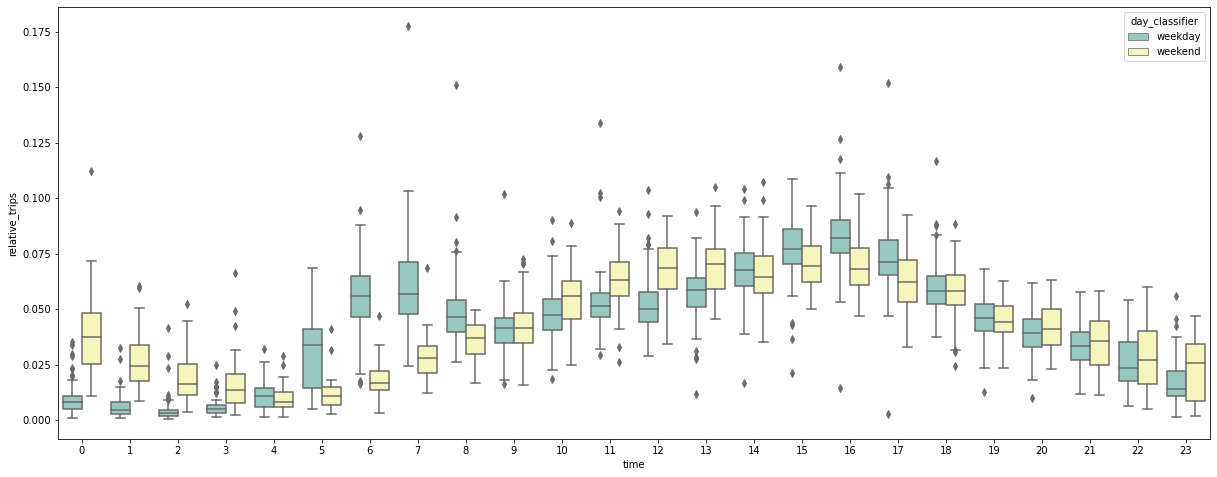

In [20]:
daily_trend = df_by_hour_merged[["time","day_classifier","relative_trips"]]

# Create a figure (empty work space)
Fig_1 = plt.figure(figsize=(16,6))

# Add axes to the figure
ax_1 = Fig_1.add_axes([0.5, 0.5, 1, 1]) #The dimensions [left, bottom, width, height] of the axes


sns.boxplot(ax = ax_1,
                 data=daily_trend, 
                 x="time", 
                 y="relative_trips", 
                 hue='day_classifier', 
                 palette="Set3")


____

# Predictive Analytics

In [ ]:
#Calculating the best Raster Point that is closest to the city center
testset_weather = pd.read_csv("./weather-data/dwd-raster/target/ra190201_target.csv") 

distances_center = []
for index, row in testset_weather.iterrows():
        d = {
            "LON": row["LON"],
            "LAT": row["LAT"],
            "ID": row["ID"],
            "distance": calculate_distance(row["LON"], row["LAT"], leipzig["lng"], leipzig["lat"])
        } 
        distances_center.append(d)
distances_center = pd.DataFrame(distances_center)

C:\Users\Leon\anaconda3\envs\aa\lib\site-packages\pandas\core\frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


                  LAT        LON  VAL
2019-02-01  51.341667  12.366667    0
2019-02-02  51.341667  12.366667    0
2019-02-03  51.341667  12.366667   40
2019-02-04  51.341667  12.366667    0
2019-02-05  51.341667  12.366667    0


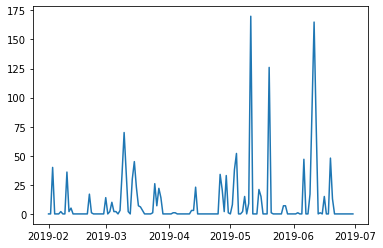

In [21]:

raster_id = distances_center.iloc[distances_center["distance"].idxmin()]["ID"]

path = './weather-data/dwd-raster/target/'

import os
rain_data_all = pd.concat((pd.read_csv(path+filename) for filename in os.listdir(path)))

rain_data = rain_data_all[rain_data_all["ID"] == raster_id]
rain_data.index = dates
rain_data.drop(columns=["ID"],inplace=True)

plt.plot(rain_data.index,rain_data.VAL)

No handles with labels found to put in legend.


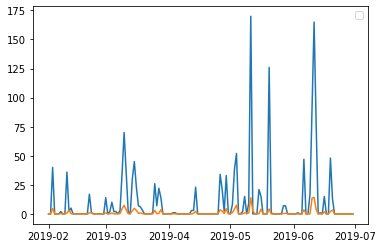

In [31]:
meteostat_leipzig = pd.read_csv("./weather-data/meteostat-leipzig.csv") 
meteostat_leipzig.index = dates
meteostat_leipzig

plt.plot(rain_data.index,rain_data.VAL)
plt.plot(meteostat_leipzig.index,meteostat_leipzig.prcp)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [133]:
df_predictive = df_by_date_merged
df_predictive["weekday_dummy"] = df_predictive["day_classifier"].isin(["weekday"]).astype(int)
df_predictive = df_predictive.join(rain_data)
df_predictive = df_predictive.drop(columns={"day_classifier","usage","daily_revenue","daily_used_bikes","LAT","LON"})

In [155]:
X = df_predictive.drop(columns="daily_trips")
Y = df_predictive[["daily_trips"]]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3)


R2: 0.8444684930216279


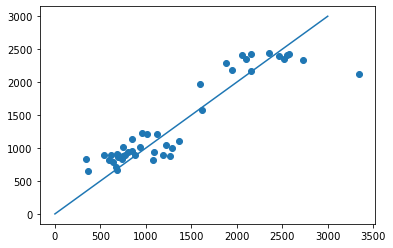

In [156]:
lin_reg_mod = LinearRegression()
lin_reg_mod.fit(X_train, Y_train)
pred = lin_reg_mod.predict(X_test)

test_set_r2 = r2_score(Y_test, pred)
plt.scatter(Y_test, pred)

x = np.linspace(0, 3000, 3000)
print("R2:", test_set_r2)
plt.plot(x,x)

_______________________________

# Geographic Clustering for availability analysis

In [ ]:
locs = df[["orig_lat","orig_lng"]].rename(columns={"orig_lat": "lat","orig_lng":"lng"})
locs.append(df[["dest_lat","dest_lng"]].rename(columns={"dest_lat": "lat","dest_lng":"lng"}),ignore_index=True)
locs

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans

ssd = []
for i in range(2, 60):
    km = MiniBatchKMeans(n_clusters=i)
    km.fit_predict(locs)
    ssd.append(km.inertia_)
    
plt.plot(ssd)

In [ ]:
n = 40

km = MiniBatchKMeans(n_clusters=n)
km.fit_predict(locs)
clusters = pd.DataFrame(km.cluster_centers_)
clusters.columns = ['lat', 'lng']
clusters_gdf = gpd.GeoDataFrame(
    clusters.drop(["lat","lng"],axis=1), geometry=gpd.points_from_xy(clusters["lng"], clusters["lat"]))

In [ ]:
locs_gdf = gpd.GeoDataFrame(
    locs.drop(["lat","lng"],axis=1), geometry=gpd.points_from_xy(locs["lng"], locs["lat"]))

In [ ]:
leipzig_map = gpd.read_file("./resources/leipzig/ot.shp").to_crs(epsg=4326) #original file is in a different system

fig, ax = plt.subplots(figsize=(30,20))

locs_gdf.plot(ax=ax, alpha=0.2, color = [0,0,0], markersize=10, zorder=2)
clusters_gdf.plot(ax=ax, alpha=0.7, color='cyan', markersize=75,  zorder=3)
leipzig_map.plot(ax=ax, alpha=0.4, edgecolor='darkgrey', color='lightgrey', zorder=1)

## Availability Analysis
This function calculates what happened between rental times. It analyzes whether, between rentals, a bike has been available at a certain station or whether it has been moved to a different location. This can then be used for example to calculate the number of available bikes at a certain station at a single time. We use it to calculate our KPI of percentage of stations without available bikes. It can be used for further analysis in this topic as well.

In [26]:
round_factor = 2
df

,b_number,city,trip_duration,orig_lat,orig_lng,dest_lat,dest_lng,timestamp,timestamp_rounded,Weekday,Week,Time,date,date_str,revenue
0,10900,leipzig,0 days 00:12:00,51.330271,12.341983,51.330347,12.342159,2019-04-16 11:17:00,2019-04-16 11:00:00,1,16,11,2019-04-16,2019-04-16,1.0
1,10900,leipzig,0 days 00:08:00,51.330347,12.342159,51.330271,12.342199,2019-04-16 11:35:00,2019-04-16 11:00:00,1,16,11,2019-04-16,2019-04-16,1.0
2,10900,leipzig,0 days 00:40:00,51.330267,12.342196,51.330236,12.342012,2019-04-16 11:53:00,2019-04-16 11:00:00,1,16,11,2019-04-16,2019-04-16,2.0
3,10900,leipzig,0 days 00:03:00,51.330298,12.341811,51.330267,12.341958,2019-04-16 14:35:00,2019-04-16 14:00:00,1,16,14,2019-04-16,2019-04-16,1.0
4,20000,leipzig,0 days 00:20:00,51.343107,12.376471,51.330422,12.337838,2019-05-21 09:47:00,2019-05-21 09:00:00,1,21,9,2019-05-21,2019-05-21,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185322,99979,leipzig,0 days 00:07:00,51.468822,11.290048,51.468547,11.289899,2019-05-25 10:58:00,2019-05-25 10:00:00,5,21,10,2019-05-25,2019-05-25,1.0
185323,99979,leipzig,0 days 01:16:00,51.468756,11.289723,51.469324,11.289366,2019-05-27 09:32:00,2019-05-27 09:00:00,0,22,9,2019-05-27,2019-05-27,3.0
185324,99979,leipzig,0 days 00:03:00,51.469044,11.289348,51.469093,11.289432,2019-05-27 11:02:00,2019-05-27 11:00:00,0,22,11,2019-05-27,2019-05-27,1.0
185325,99982,leipzig,0 days 01:44:00,51.341165,12.365045,51.341065,12.365005,2019-02-11 11:47:00,2019-02-11 11:00:00,0,7,11,2019-02-11,2019-02-11,4.0


In [27]:
df2 = df[:]

df2["timestamp_end"] = df2["timestamp"] + df2["trip_duration"]
df2=df2.drop(columns=['date', 'date_str', "revenue", "Weekday", "Time", "timestamp_rounded","trip_duration"])

#df2 = df2.round({"orig_lat":round_factor, 'orig_lng':round_factor, 'dest_lat':round_factor, "dest_lng":round_factor})

#make sure it is sorted by b_number, then timestamp
df2 = df2.sort_values(by=['b_number','timestamp'])
#make sure the index is still +1 every time after sorting
df2.reset_index(inplace=True)
df2 = df2.rename(columns={"index": "original_index"})


df2

<ipython-input-27-5187e125bb26>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["timestamp_end"] = df2["timestamp"] + df2["trip_duration"]


,original_index,b_number,city,orig_lat,orig_lng,dest_lat,dest_lng,timestamp,Week,timestamp_end
0,0,10900,leipzig,51.330271,12.341983,51.330347,12.342159,2019-04-16 11:17:00,16,2019-04-16 11:29:00
1,1,10900,leipzig,51.330347,12.342159,51.330271,12.342199,2019-04-16 11:35:00,16,2019-04-16 11:43:00
2,2,10900,leipzig,51.330267,12.342196,51.330236,12.342012,2019-04-16 11:53:00,16,2019-04-16 12:33:00
3,3,10900,leipzig,51.330298,12.341811,51.330267,12.341958,2019-04-16 14:35:00,16,2019-04-16 14:38:00
4,4,20000,leipzig,51.343107,12.376471,51.330422,12.337838,2019-05-21 09:47:00,21,2019-05-21 10:07:00
...,...,...,...,...,...,...,...,...,...,...
185322,185322,99979,leipzig,51.468822,11.290048,51.468547,11.289899,2019-05-25 10:58:00,21,2019-05-25 11:05:00
185323,185323,99979,leipzig,51.468756,11.289723,51.469324,11.289366,2019-05-27 09:32:00,22,2019-05-27 10:48:00
185324,185324,99979,leipzig,51.469044,11.289348,51.469093,11.289432,2019-05-27 11:02:00,22,2019-05-27 11:05:00
185325,185325,99982,leipzig,51.341165,12.365045,51.341065,12.365005,2019-02-11 11:47:00,7,2019-02-11 13:31:00


This step will take a while, as it clusters each entry to a specific cluster point, which takes a lot of computing power.

In [28]:
df3 = []

bike_number = 0
bike_city = ""

for index in df2.index:
    if  df2.at[index,"b_number"] != bike_number:
        bike_number = df2.at[index,"b_number"]
        bike_city = df2.at[index,"city"]
    else:
        lat = df2.at[index,"orig_lat"]
        lng = df2.at[index,"orig_lng"]
        cluster_point = next_cluster(lng,lat,clusters)
        time_start = df2.at[index-1,"timestamp_end"]
        time_end = df2.at[index,"timestamp"]
        
        #test if it is working
        if index % 20000 == 0:
            print("reached row", index, "of", df2.index.max())
        
        action_type = "station"
        if lat == df2.at[index-1,"dest_lat"] and lng != df2.at[index-1,"dest_lng"]:
            action_type = "moved"
            
        d = {
            'b_number' : bike_number,
            'b_city' : bike_city,
            'lat' : lat,  # some formula for obtaining values
            'lng' : lng,
            'timestamp' : time_start,
            'action_type' : action_type+"_in",
            'cluster_point': cluster_point
            }
        df3.append(d)
        d = {
            'b_number' : bike_number,
            'b_city' : bike_city,
            'lat' : lat,  # some formula for obtaining values
            'lng' : lng,
            'timestamp' : time_end,
            'action_type' : action_type+"_out",
            'cluster_point': cluster_point
            }
        df3.append(d)

df3 = pd.DataFrame(df3)

reached row 20000 of 185326
reached row 40000 of 185326
reached row 60000 of 185326
reached row 80000 of 185326
reached row 100000 of 185326
reached row 120000 of 185326
reached row 140000 of 185326
reached row 160000 of 185326
reached row 180000 of 185326


In [29]:
df3["cluster_point"] = df3["cluster_point"].astype(str)
df3

,b_number,b_city,lat,lng,timestamp,action_type,cluster_point
0,10900,leipzig,51.330347,12.342159,2019-04-16 11:29:00,station_in,"[12.336177757886452, 51.33104725722249]"
1,10900,leipzig,51.330347,12.342159,2019-04-16 11:35:00,station_out,"[12.336177757886452, 51.33104725722249]"
2,10900,leipzig,51.330267,12.342196,2019-04-16 11:43:00,station_in,"[12.336177757886452, 51.33104725722249]"
3,10900,leipzig,51.330267,12.342196,2019-04-16 11:53:00,station_out,"[12.336177757886452, 51.33104725722249]"
4,10900,leipzig,51.330298,12.341811,2019-04-16 12:33:00,station_in,"[12.336177757886452, 51.33104725722249]"
...,...,...,...,...,...,...,...
368633,99979,leipzig,51.468822,11.290048,2019-05-25 10:58:00,station_out,"[12.293552020833314, 51.35209568750001]"
368634,99979,leipzig,51.468756,11.289723,2019-05-25 11:05:00,station_in,"[12.293552020833314, 51.35209568750001]"
368635,99979,leipzig,51.468756,11.289723,2019-05-27 09:32:00,station_out,"[12.293552020833314, 51.35209568750001]"
368636,99979,leipzig,51.469044,11.289348,2019-05-27 10:48:00,station_in,"[12.293552020833314, 51.35209568750001]"


This algorithm takes goes over all records that relate to bikes standing at a certain station. For each change event, it calculates the effect on the capacity of a certain station.

In [30]:
#filter df3 for all events related to bikes standing at a station (not being moved between rides)
df3 = df3[df3["action_type"].isin(["station_in","station_out"])]

#filter correctly for the algorithm to work properly
df3=df3.sort_values(by=['cluster_point','timestamp','action_type'])
df3.reset_index(inplace=True)
df3 = df3.rename(columns={"index": "original_index"})

df3["count"] = 0

station = ""
count = 0

for index in df3.index:
    action_type = df3.at[index,"action_type"]
    #if this is a different station, restart the calculation
    if  df3.at[index,"cluster_point"] != station:
        station = df3.at[index,"cluster_point"]
        count = 0
    if action_type == "station_in":
         count = count + 1
    elif action_type == "station_out":
        count = count - 1
    else:
        print("there was an error")
    
    df3.at[index,"count"] = count

In [31]:
df3

,original_index,b_number,b_city,lat,lng,timestamp,action_type,cluster_point,count
0,138504,23140,leipzig,51.350020,12.291401,2019-02-01 07:24:00,station_in,"[12.293552020833314, 51.35209568750001]",1
1,156914,23188,leipzig,51.350020,12.291401,2019-02-01 10:19:00,station_in,"[12.293552020833314, 51.35209568750001]",2
2,156915,23188,leipzig,51.350020,12.291401,2019-02-01 13:06:00,station_out,"[12.293552020833314, 51.35209568750001]",1
3,303764,23569,leipzig,51.353337,12.303199,2019-02-01 16:21:00,station_in,"[12.293552020833314, 51.35209568750001]",2
4,138505,23140,leipzig,51.350020,12.291401,2019-02-01 17:03:00,station_out,"[12.293552020833314, 51.35209568750001]",1
...,...,...,...,...,...,...,...,...,...
355537,66037,20370,leipzig,51.344938,12.422246,2019-06-30 16:16:00,station_out,"[12.42794056727791, 51.349536043850115]",4
355538,19375,20247,leipzig,51.342796,12.427372,2019-06-30 17:25:00,station_out,"[12.42794056727791, 51.349536043850115]",3
355539,208723,23314,leipzig,51.342911,12.427218,2019-06-30 17:25:00,station_out,"[12.42794056727791, 51.349536043850115]",2
355540,291793,23539,leipzig,51.343262,12.427448,2019-06-30 17:25:00,station_out,"[12.42794056727791, 51.349536043850115]",1


This part produces a list of the minimum available bikes at a certain station. For example, if a station has had 2 bikes for the first ten minutes, then had 3 and in the end had only 1 bike left, this would count as 1 bike for the respective hour period. 
* If there was no change in available bikes, it takes the value for the most recent change event.
* If the number of available bikes changes to zero and no bikes ever get to the station again until the end of the data timeframe, it will not count as 0 bikes as the station might have been closed in the meantime (this should not count as "no bikes available)

In [32]:
df3["timestamp_rounded"] = df3["timestamp"].dt.floor("H")
df3 = df3.sort_values(by=['cluster_point','timestamp'])

start_date = df3.timestamp_rounded.min()
end_date = df3.timestamp_rounded.max()
daterange = pd.date_range(start_date, end_date,freq='1H')

df4 = pd.DataFrame(index=daterange)

for cluster_point in df3.cluster_point.unique():
    dfl = df3[df3.cluster_point == cluster_point]
    dfl = dfl.groupby("timestamp_rounded").agg(
    min_count =("count","min"),
    last_value = ("count", lambda x: x.iloc[-1]))
    dfl = dfl.reindex(daterange, fill_value=None)
    dfl["last_value"] = dfl["last_value"].fillna(method='ffill')
    dfl["min_count"] = dfl.apply(
        lambda row: row['last_value']if np.isnan(row['min_count']) else row['min_count'],axis=1
    )
    for index, row in dfl[::-1].iterrows():
        if row["min_count"] == 0:
            row["min_count"] = None
        else:
            break
    df4[cluster_point] = dfl["min_count"]
    
df4 = df4.T

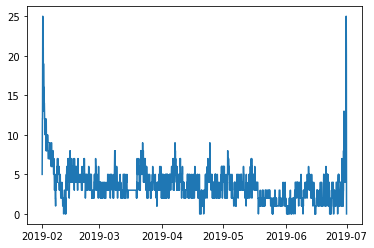

In [36]:
#df4.to_excel("transposed.xlsx")
df5 = df4[df4 < 4].count()
df5
plt.plot(df5)

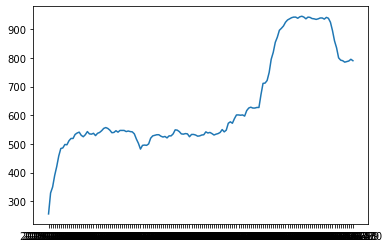

In [37]:
plt.plot(fleet_size)

_______________________________

## Visualisation

In [ ]:
dates = df_by_date_merged.index
fleetsize = df_by_date_merged["fleet_size"]
usage = df_by_date_merged["usage"]
usedbikes = df_by_date_merged["used_bikes"]

Fig_1, ax_1 = plt.subplots()


color = 'tab:red'
ax_1.set_xlabel('Date')
ax_1.set_ylabel('Fleet Size', color=color)
ax_1.plot(dates, fleetsize, color=color)
ax_1.tick_params(axis='y', labelcolor=color)

ax_2 = ax_1.twinx()  # instantiate a second axes that shares the same x-axis


color = 'tab:blue'

ax_2.set_ylabel("Used Bikes", color=color)
ax_2.plot(dates, usedbikes, color=color)
ax_2.tick_params(axis='y', labelcolor=color)

Fig_1.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()

## Group by rounded start time

In [ ]:
df_by_time = df.groupby("Time").agg(
    mean_length=('trip_duration', lambda x: np.mean(x)),
    trip_count=('b_number', 'count'))

In [ ]:
fig, (ax1, ax1_b) = plt.subplots(nrows = 1, ncols = 2, figsize= (12,4))

x = df_by_time.index
seconds = df_by_time["mean_length"].dt.total_seconds()/60
amount = df_by_time["trip_count"]

color = 'tab:red'
ax1.set_xlabel('Time of the day')
ax1.set_ylabel('Average trip length', color=color)
ax1.plot(x, seconds, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Total amount of trips', color=color)  # we already handled the x-label with ax1
ax2.plot(x, amount, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()